# Pip


In [7]:
%pip install torch
%pip install gymnasium
%pip install matplotlib
%pip install pygame

%pip install python-opengl -y
%pip install xvfb -y
%pip install pyvirtualdisplay
%pip install piglet
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



Usage:   
  e:\!Python\gymnasium-work\.venv\Scripts\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  e:\!Python\gymnasium-work\.venv\Scripts\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  e:\!Python\gymnasium-work\.venv\Scripts\python.exe -m pip install [options] [-e] <vcs project url> ...
  e:\!Python\gymnasium-work\.venv\Scripts\python.exe -m pip install [options] [-e] <local project path> ...
  e:\!Python\gymnasium-work\.venv\Scripts\python.exe -m pip install [options] <archive url/path> ...

no such option: -y


Note: you may need to restart the kernel to use updated packages.



Usage:   
  e:\!Python\gymnasium-work\.venv\Scripts\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  e:\!Python\gymnasium-work\.venv\Scripts\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  e:\!Python\gymnasium-work\.venv\Scripts\python.exe -m pip install [options] [-e] <vcs project url> ...
  e:\!Python\gymnasium-work\.venv\Scripts\python.exe -m pip install [options] [-e] <local project path> ...
  e:\!Python\gymnasium-work\.venv\Scripts\python.exe -m pip install [options] <archive url/path> ...

no such option: -y


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [8]:
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import Env

import warnings
warnings.filterwarnings('ignore')

import json
from typing import List, Tuple, Dict
from tqdm import tqdm

from PIL import Image


# Env

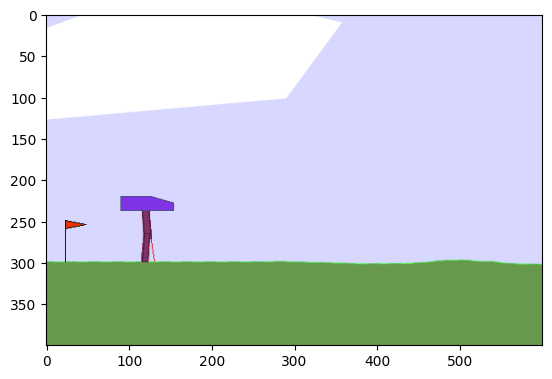

state: [ 2.7474759e-03 -8.3757614e-06  6.5153459e-04 -1.5999945e-02
  9.2034519e-02 -8.5980294e-04  8.6022699e-01  2.0384793e-03
  1.0000000e+00  3.2441515e-02 -8.5974525e-04  8.5377491e-01
  6.0806255e-04  1.0000000e+00  4.4081402e-01  4.4582012e-01
  4.6142277e-01  4.8955020e-01  5.3410280e-01  6.0246104e-01
  7.0914888e-01  8.8593185e-01  1.0000000e+00  1.0000000e+00]


In [9]:
env = gym.make('BipedalWalker-v3', render_mode="rgb_array", hardcore=False)

def draw_env(env: Env) -> None:
    plt.imshow(env.render())
    plt.show()


observation_space_bounds = [
    (3.14, -3.14), 
    (5., -5.), 
    (5., -5.), 
    (5., -5.), 
    (3.14, -3.14), 
    (5., -5.), 
    (3.14, -3.14), 
    (5., -5.), 
    (5., -0.), 
    (3.14, -3.14), 
    (5., -5.), 
    (3.14, -3.14), 
    (5., -5.), 
    (5., -0.)
]


def get_discrete_actions(steps_count_per_action=1) -> List[List[float]]:
    actions_list = []
    steps_count_per_action = 1

    action = [0.0, 0.0, 0.0, 0.0]
    actions_list.append(action)
    for joint in range(4):
        for i in range(1, steps_count_per_action + 1):
            action = [0.0, 0.0, 0.0, 0.0]
            action[joint] = i / steps_count_per_action
            actions_list.append(action)

            action = [0.0, 0.0, 0.0, 0.0]
            action[joint] = - i / steps_count_per_action
            actions_list.append(action)

    return torch.Tensor(actions_list)

actions_list = get_discrete_actions(1)

state = env.reset()[0]

draw_env(env)

print("state:", state)

In [10]:
def add_history(history: List[float], path="history.json") -> None:
    with open(path, "r") as file:
        j_obj = json.loads(file.read())

        j_obj["rewards"] += history

    with open(path, "w") as file:
        file.write(json.dumps(j_obj))

def clear_history(path="history.json") -> None:
    with open(path, "w") as file:
        file.write(json.dumps(
            { 
                "rewards": []
            }
        ))

# Q-learning


In [17]:
class AgentQLearning:
    def __init__(self, env: Env, n_states: int, steps_count_per_action: int = 1, n_features: int = 0, lr=0.15, w_gamma=0.5) -> None:
        self.env = env
        self.n_states = n_states
        self.n_features = n_features
        self.actions_list = get_discrete_actions(steps_count_per_action)

        self.models: List[torch.nn.Module] = []
        self.optimizers: List[torch.optim.Optimizer] = []
        self.criterion = torch.nn.MSELoss()

        for _ in range(len(actions_list)):
            model = torch.nn.Linear(self.n_features, 1)
            optimizer = torch.optim.SGD(model.parameters(), lr)
            self.models.append(model)
            self.optimizers.append(optimizer)

        torch.manual_seed(10)
        if (self.n_features > 0):
            self.w = torch.randn((self.n_states, self.n_features)) / w_gamma
            self.b = torch.rand((self.n_features)) * 2 * 3.1416
            
    def state_slice(self, state: torch.Tensor) -> torch.Tensor:
        return state[0: self.n_states]

    def get_features(self, state: torch.Tensor) -> torch.Tensor:
        if (self.n_features > 0):
            return (2.0 / self.n_features) ** 0.5 * torch.cos(torch.matmul(state.float(), self.w) + self.b)
        return state

    def get_action_id(self, state: torch.Tensor, eps: float) -> int:
        """Epsilon greedy policy"""
        if torch.rand((1, )).item() < eps:
            action_id = torch.randint(0, len(self.actions_list), (1,))
        else:
            action_id = torch.argmax(self.get_q_value_all(state))
        return action_id.item()

    def get_q_value_all(self, state: torch.Tensor) -> List[float]:
        y_preds = []
        for i in range(len(self.actions_list)):
            y_preds.append(self.get_q_value(state, i))
        return torch.Tensor(y_preds)

    def get_q_value(self, state: torch.Tensor, action_id: int) -> float:
        features = self.get_features(state)
        y_pred = self.models[action_id](features)
        return y_pred.item()

    def update_models(self, state: torch.Tensor, action_id: int, target_q_value: float) -> None:
        features = self.get_features(state)
        y_pred = self.models[action_id](features)
        loss = self.criterion(y_pred, torch.Tensor([target_q_value]))
        self.optimizers[action_id].zero_grad()
        loss.backward()
        self.optimizers[action_id].step()

    def train(self, n_episodes: int, gamma=0.5, eps_max=0.5, eps_min=0.1, actions_limit=1_000) -> List[float]:
        total_reward_episode: List[float] = []

        for episode_i in tqdm(range(n_episodes)):
            total_reward = 0

            is_done = False

            state = self.state_slice(torch.Tensor(self.env.reset()[0]))

            action_count = 0
            while not is_done and action_count < actions_limit:
                action_id = self.get_action_id(state, eps_max - (eps_max - eps_min) / n_episodes * episode_i)
                action = self.actions_list[action_id]

                new_state, reward, terminated, truncated,  _ = self.env.step(action)
                is_done = terminated or truncated

                new_state = self.state_slice(torch.Tensor(new_state))            

                q_values_next = self.get_q_value_all(new_state)
                
                # Q-learning
                target_q_value = reward + gamma * torch.max(q_values_next)

                self.update_models(state, action_id, target_q_value)

                action_count += 1
                total_reward += reward
                state = new_state

            total_reward_episode.append(total_reward.item())

        return total_reward_episode


    def run_episode(self, eps=0.0, actions_limit=1_000) -> Tuple[List, List, List, float, bool, int]:
        """Tests and visualizes the agent's work"""
        states = []
        actions_set = set([])
        actions_distr = [0, ] * len(self.actions_list)
        is_done = False

        state = self.state_slice(torch.Tensor(self.env.reset()[0]))

        images = []
        total_reward = 0
        action_count = 0

        while not is_done and len(images) < actions_limit:
            action_id = self.get_action_id(state, eps)
            action = self.actions_list[action_id]
            
            new_state, reward, terminated, truncated,  _ = self.env.step(action)
            is_done = terminated or truncated
            new_state = self.state_slice(torch.Tensor(new_state))

            total_reward += reward
            actions_set.add(action_id)
            actions_distr[action_id] += 1

            action_count += 1
            state = new_state

            if (action_count % 3 == 0):
                images.append(Image.fromarray(self.env.render()[30:350, 0:300]))

        images[0].save("array.gif", save_all=True, append_images=images[1:], optimize=True, duration=0.05, loop=0)

        return states, actions_set, actions_distr, total_reward.item(), is_done, len(images)


    def save(self, dir: str) -> None:
        for i in range(len(self.models)):
            torch.save(self.models[i].state_dict(), f"{dir}/model_{i}")

    def load(self, dir: str) -> None:
        len_models = len(self.models)
        self.models = []
        for i in range(len_models):
            model = torch.nn.Linear(self.n_features, 1)
            model.load_state_dict(torch.load(f"{dir}/model_{i}"))
            self.models.append(model)

## Training

In [18]:
q_learning_model = AgentQLearning(env, 24, steps_count_per_action=1, n_features=24, lr=0.02)

In [19]:
q_learning_model.load("models_q_learning_1_1")

In [ ]:
history_rewards = q_learning_model.train(n_episodes=1_000, gamma=0.98, eps_max=0.8, eps_min=0.1, actions_limit=800)
print(history_rewards)
add_history(history_rewards)

In [21]:
q_learning_model.save("models_q_learning_1_2")

In [22]:
states, actions_set, actions_distr, reward, is_done, size = q_learning_model.run_episode(eps=0.0, actions_limit=400)
print(reward)
print(actions_distr)
print(size)

6.23003388329728
[0, 2, 0, 397, 2, 577, 222, 0, 0]
400
